In [1]:
import os
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
import functools
import glob
import scipy

import geopandas as gpd
from shapely.geometry import *

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33121 instead
  warnings.warn(


In [3]:
cluster.scale(10)
client = Client(cluster)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    return xa

In [5]:
def byhand(t,p):
    t1 = -5  #    tundra-boreal
    t2 =  3  #    boreal-temperate
    t3 = 20  # temperate-tropical

    tvals = [-np.inf,t1,t2,t3,np.inf]
    bvals = [9,8,4,1]


    for i in range(4):
        if (t>tvals[i])&(t<=tvals[i+1]):
            b = bvals[i]

    td = 15; pd=60; bd=3  #desert
    if (t>td)&(p<pd):
        b = bd

    return b

In [6]:
def get_bclass(n, ta, pr, gpp, data):
    
    ncell = len(ta)
    bclass = np.zeros(ncell) + np.nan
    
    for c in range(ncell):
        if (ta[c] < 0) & (gpp[c] == 0):
            bclass[c] = 0  #ice
        else:
            ptf = gpd.GeoDataFrame({'geometry':[Point(ta[c],pr[c])]})
            x=gpd.overlay(ptf, data, how='intersection')
            if len(x)>0:
                bclass[c] = x.biome_id.values[0]
            else:
                bclass[c] = byhand(ta[c],pr[c])
    return bclass
    

In [7]:
def get_surdat(surdat_file):

    surdat = xr.open_dataset(surdat_file)

    # set actual latitude and longitude values as the dimension values
    surdat['lat'] = xr.DataArray(np.unique(surdat.LATIXY.values), dims='lsmlat')
    surdat['lon'] = xr.DataArray(np.unique(surdat.LONGXY.values), dims='lsmlon')
    surdat = surdat.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

    return surdat

In [8]:
def get_dom_pft_landmask(surdat, pft_indices, dominance_threshold):

    # subset surface data by pft
    # we allow more than one so that we can combine pfts (for FATES - CLM compatibility)
    pft_dat = surdat.where(surdat.natpft.isin(pft_indices))

    combined = pft_dat.PCT_NAT_PFT.sum(dim='natpft').to_dataset(name="PCT_NAT_PFT")

    dom_pft = combined.where(combined.PCT_NAT_PFT > dominance_threshold)

    # get number of gridcells
    cells = dom_pft.PCT_NAT_PFT.values
    num_gridcells = len(cells[~np.isnan(cells)])

    # create the landmask
    dom_pft['landmask'] = xr.where(~np.isnan(dom_pft.PCT_NAT_PFT), 1.0, 0.0)
    dom_pft['mod_lnd_props'] = dom_pft.landmask

    return num_gridcells, dom_pft

In [9]:
def plot_gridcells(domfpt, gridcells, pft, dom):
    fig, ax = plt.subplots(figsize=(13, 6), subplot_kw=dict(projection=ccrs.Robinson()))
    ax.set_extent([-180, 180, -56, 85], crs=ccrs.PlateCarree())
    ax.set_title(f"Dominant (>{dom}%) gridcells (n = {gridcells}) for {pft}", loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ocean = ax.add_feature(
            cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    cmap = copy.copy(plt.get_cmap('viridis', 11))
    im = ax.pcolormesh(dompft.lon, dompft.lat, dompft.PCT_NAT_PFT,
                   transform=ccrs.PlateCarree(),
                   vmin=0, vmax=100, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction = 0.03, orientation='horizontal')
    cbar.set_label('Percent PFT (%)', size=12, fontweight='bold')

In [10]:
def preprocess(ds):
    dvs = ['TLAI', 'GPP', 'TBOT', 'RAIN', 'SNOW', 'area', 'landfrac']
    return ds[dvs]

In [11]:
def get_biome_map():

    # Load full grid CLM simulation at 2degree
    d = '/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
    files = sorted(glob.glob(d+'*h0*'))[-84:]

    tmp = xr.open_dataset(files[0])
    
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time',
                           parallel=True, preprocess=preprocess,
                           decode_times=False)
    ds['time'] = xr.cftime_range('2007', periods=84, freq='MS',
                                 calendar='noleap')

    # calculate temperature and precip for each gridcell
    cf = 24*60*60*365/10
    tbot = amean(ds.TBOT).mean(dim='year') - 273.15  # degC
    rain = cf*amean(ds.RAIN).mean(dim='year')  # cm/yr
    snow = cf*amean(ds.SNOW).mean(dim='year')  # cm/yr
    prec = rain + snow

    landfrac = ds.isel(time=0).landfrac
    area = ds.isel(time=0).area

    ta = tbot.values.reshape(-1,1)
    pr = prec.values.reshape(-1,1)

    gpp_clim = amean(ds.GPP).mean(dim='year').compute()

    gpp = gpp_clim.values.reshape(-1, 1)

    fp = '/glade/work/afoster/FATES_calibration/CLM5PPE/pyth/whit/Whittaker_biomes.shp'
    data = gpd.read_file(fp)
    newb = np.array([9, 8, 7, 6, 5, 4, 1, 2, 3])
    data.biome_id = newb # more logical order

    tmp = get_bclass(1, ta, pr, gpp, data)

    Biome_ID = tmp.reshape(np.shape(tbot)[0], np.shape(tbot)[1])

    ds_biomeID = xr.DataArray(Biome_ID, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

    whit = xr.open_dataset('/glade/work/afoster/FATES_calibration/CLM5PPE/pyth/whit/whitkey.nc')
    whit.biome_name

    ds_out = ds_biomeID.to_dataset(name='biome')
    ds_out['biome_name'] = whit.biome_name

    ds_out['landfrac'] = landfrac
    ds_out['area'] = area

    ds_out['biome'] = xr.where(ds_out.landfrac > 0.0, ds_out.biome, -9999)
    ds_masked = ds_out.where(ds_out['biome'] != -9999)

    return ds_masked

In [12]:
def write_dompft(surdat, pft_index, dominance_threshold, out_dir, pftname):
    
    gridcells, dompft = get_dom_pft_landmask(surdat, pft_index, dominance_threshold)
    
    file_out = os.path.join(out_dir, f"{pftname}_grid_presence.nc")
    
    # need encoding for ncks to work
    encoding = {'lat': {'_FillValue': False},
                'lon': {'_FillValue': False},
                'landmask': {'_FillValue': False}}
    dompft.to_netcdf(file_out, encoding=encoding)

In [13]:
def get_dom_mask(dompft, ds_biomeID):
    
    ds_interp = ds_biomeID.interp(lat=dompft["lat"], lon=dompft["lon"], method='nearest')
    merged = xr.merge([ds_interp, dompft])
    merged['land_area'] = merged.landmask*merged.area
    sub = merged.where(merged.landmask == 1)

    return sub

In [14]:
def plot_pft_biomes(dom_mask, pft):
    biome_names = ['Ice sheet', 'Tropical rain forest',
                   'Tropical seasonal forest/savanna', 'Subtropical desert',
                   'Temperate rain forest', 'Temperate seasonal forest',
                   'Woodland/shrubland', 'Temperate grassland/desert',
                   'Boreal forest', 'Tundra']
    colors = ["#ADADC9", "#317A22", "#A09700", "#DCBB50", "#75A95E", "#97B669",
              "#D16E3F", "#FCD57A", "#A5C790", "#C1E1DD"]
    
    cmap = matplotlib.colors.ListedColormap(colors)
    
    fig, ax = plt.subplots(figsize=(13, 6),
                           subplot_kw=dict(projection=ccrs.Robinson()))
    
    ax.set_title(pft, loc='left', fontsize='large', fontweight='bold')
    
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m',
                                                        facecolor='white'))
    
    pcm = ax.pcolormesh(dom_mask.lon, dom_mask.lat, dom_mask.biome,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=-0.5,
                        vmax=9.5)
    
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.03,
                        orientation='vertical')
    cbar.set_label('Biome', size=12, fontweight='bold')
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cbar.set_ticklabels(biome_names)
    plt.savefig(f'biome_pfts/{pft}_biome.png')

In [197]:
def get_pft_biomes(surdat, pft, ds_biomeID, dominance_threshold):

    pft_indices = fates_clm_ind[pft]
    gridcells, dompft = get_dom_pft_landmask(surdat, pft_indices, dominance_threshold)
    dom_mask = get_dom_mask(dompft, ds_biomeID)

    plot_pft_biomes(dom_mask, pft)

    biome_names = ['Ice sheet', 'Tropical rain forest',
               'Tropical seasonal forest/savanna', 'Subtropical desert',
               'Temperate rain forest', 'Temperate seasonal forest',
               'Woodland/shrubland', 'Temperate grassland/desert',
               'Boreal forest', 'Tundra']

    pft_area = []
    for i in range(len(biome_names)):
        pft_area.append(dom_mask.where(dom_mask.biome == i).land_area.sum().values)
    land_sum = np.sum(pft_area)
    pft_prop = pft_area/land_sum*100

    data = {'pft_area': pft_area,
            'pft_prop': pft_prop,
            'pft': np.repeat(pft, len(biome_names)),
            'biome_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            'biome_name': biome_names}
    df = pd.DataFrame(data)

    return df
    

In [15]:
fates_clm_ind = {"broadleaf_evergreen_tropical_tree": [4],
             "needleleaf_evergreen_extratrop_tree": [2, 1],
             "needleleaf_colddecid_extratrop_tree": [3],
             "broadleaf_evergreen_extratrop_tree": [5],
             "broadleaf_hydrodecid_tropical_tree": [6],
             "broadleaf_colddecid_extratrop_tree": [8, 7],
             "broadleaf_evergreen_extratrop_shrub": [9],
             "broadleaf_hydrodecid_extratrop_shrub": [11, 10],
             "broadleaf_colddecid_extratrop_shrub": [11, 10],
             "arctic_c3_grass": [12],
             "cool_c3_grass": [13],
             "c4_grass": [14]}

In [16]:
fates_clm = {"broadleaf_evergreen_tropical_tree": ["broadleaf_evergreen_tropical_tree"],
             "needleleaf_evergreen_extratrop_tree": ["needleleaf_evergreen_boreal_tree", 
                                                     "needleleaf_evergreen_temperate_tree"],
             "needleleaf_colddecid_extratrop_tree": ["needleleaf_deciduous_boreal_tree"],
             "broadleaf_evergreen_extratrop_tree": ["broadleaf_evergreen_temperate_tree"],
             "broadleaf_hydrodecid_tropical_tree": ["broadleaf_deciduous_tropical_tree"],
             "broadleaf_colddecid_extratrop_tree": ["broadleaf_deciduous_boreal_tree",
                                                    "broadleaf_deciduous_temperate_tree"],
             "broadleaf_evergreen_extratrop_shrub": ["broadleaf_evergreen_shrub"],
             "broadleaf_hydrodecid_extratrop_shrub": ["broadleaf_deciduous_boreal_shrub",
                                                      "broadleaf_deciduous_temperate_shrub"],
             "broadleaf_colddecid_extratrop_shrub": ["broadleaf_deciduous_boreal_shrub", 
                                                     "broadleaf_deciduous_temperate_shrub"],
             "arctic_c3_grass": ["c3_arctic_grass"],
             "cool_c3_grass": ["c3_non-arctic_grass"],
             "c4_grass": ["c4_grass"]}

In [17]:
surdat_dir = "/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/"
surdat_2deg = os.path.join(surdat_dir, "release-clm5.0.18", "surfdata_1.9x2.5_hist_16pfts_Irrig_CMIP6_simyr2000_c190304.nc")
surdat_1deg = os.path.join(surdat_dir, "release-clm5.0.18", "surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc")
surdat_025deg = os.path.join(surdat_dir, "surfdata_360x720cru_78pfts_CMIP6_simyr2000_c170706.nc")
paramfile = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c211112.nc'

In [18]:
surdat = get_surdat(surdat_2deg)

In [29]:
surdat

<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 144, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nlevurb: 5, nglcecp1: 11, nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lat                      (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                      (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Dimensions without coordinates: nlevsoi, lsmpft, numurbl, numrad, nlevurb,
                                nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lat, lon) int32 ...
    PCT_SAND                 (nlevsoi, lat, lon) float64 ...
    PCT_CLAY                 (nlevsoi, lat, lon) float64 ...
    ORGANIC                  (nlevsoi, lat, lon) float64 ...
    FMAX                     (lat, lon) float64 ...
    ...                       ...
    CONST_HARVEST_SH2        (lat, lon) float64 ...
    CONST_HARVEST_SH3        (lat, lon) float64 ...
    CONST_GRAZING            (lat, lon) float64 ...
    CONST_FERTNITRO_CFT      (cft, lat, lon) float64 ...
    UNREPRESENTED_PFT_LULCC  (natpft, lat, lon) float64 ...
    UNREPRESENTED_CFT_LULCC  (cft, lat, lon) float64 ...
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 03-04-19 21:18:11
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_1.9x2.5_nomask...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

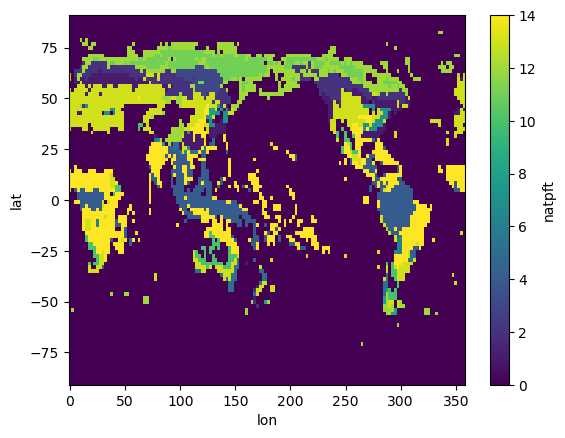

In [28]:
surdat.PCT_NAT_PFT.idxmax('natpft').plot()

In [19]:
params = xr.open_dataset(paramfile)
pftnames = [str(pftname).replace("b'", "").replace("'", "").strip() for pftname in params.pftname.values]

In [20]:
clm_pfts = pftnames[:15]
fates_pfts = list(fates_clm.keys())

In [21]:
#ds_biomeID = get_biome_map()
ds_biomeID = xr.open_dataset('../surfdata/biome_2deg.nc')

In [24]:
#pft_dat = []
#for pft in fates_pfts:
    #pft_dat.append(get_pft_biomes(surdat, pft, ds_biomeID, 60))
#df = pd.concat(pft_dat)
#df.to_csv('pft_area_biome_dom.csv')